# **Working memory training**: behavioral progress during fMRI scanning sessions

The code below allows to visualize and analize data from 6-week working memory training study. Participants were scanned four times while performing dual n-back (Jaeggi et al., 2018). 

Three performance measures were calculated: 

- accuracy
- d-prime (dprime)
- penallized reaction time (prt)

Karolina Finc | Centre for Modern Interdisciplinary Technologies, Nicolaus Copernicus University in Toruń, Poland

**Last edited:** 05-29-2019

Step 0: Setup
--------------------------------------

In [18]:
# Loading packages
library(psych)
library(tidyverse)
library(data.table)
library(nlme)
library(broom)

# Customizing theme for plotting
theme_training <- theme_bw() + theme(axis.text.y = element_text(size=25, colour='#262626ff'),
          axis.text.x = element_text(size=25, colour='#262626ff'),
          axis.title.y = element_text(size=25, colour='#262626ff'),
          axis.title.x  = element_text(size=25, colour='#262626ff'),
          plot.title = element_text(hjust=0.5, size=25),
          panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour="#262626ff"),
          panel.border = element_rect(colour = "#262626ff", fill=NA, size=1.8),
          panel.background = element_rect(fill="transparent",colour=NA),
          plot.background = element_rect(fill="transparent",colour=NA),
          legend.key = element_rect(fill= "transparent", colour="transparent"),
          strip.background =element_rect(fill="transparent", colour=NA),
          strip.text = element_text(size=25),
          axis.ticks = element_line(colour="#262626ff", size=1, 2),
          axis.ticks.length = unit(.15, "cm"),
          aspect.ratio = 1)

Step 1: Preparing data
--------------------------------------

In [19]:
# Setting working directory
setwd("~/Dropbox/Projects/LearningBrain/")

# Loading data
performance <- read.csv("data/behavioral/WM_fmri_behaviour_tidy.csv")
performance$Condition <- factor(performance$Condition, labels = c('1-back', '2-back'))
performance$Group <- factor(performance$Group, levels = c('Experimental', 'Control'))

performance$Session <- as.factor(performance$Session)
performance$Session <- factor(performance$Session, labels = c('Naive', 'Early', 'Middle', 'Late'))

beh_mean <- performance %>% 
            group_by(Subject, Session, Condition, Group) %>%
            summarize(pRT = mean(pRT), Dprime = mean(Dprime), Accuracy = mean(Accuracy))

write.csv(beh_mean, 'data/behavioral/WM_fmri_behaviour_mean_tidy.csv', row.names = FALSE)

# Checking data
glimpse(beh_mean)
summary(beh_mean)

Observations: 368
Variables: 7
$ Subject   <fct> sub-01, sub-01, sub-01, sub-01, sub-01, sub-01, sub-01, s...
$ Session   <fct> Naive, Naive, Early, Early, Middle, Middle, Late, Late, N...
$ Condition <fct> 1-back, 2-back, 1-back, 2-back, 1-back, 2-back, 1-back, 2...
$ Group     <fct> Control, Control, Control, Control, Control, Control, Con...
$ pRT       <dbl> 1.1341833, 1.4081333, 1.0987267, 1.2989117, 1.2599350, 1....
$ Dprime    <dbl> 3.930504, 2.955257, 3.576191, 3.331783, 2.917587, 3.39458...
$ Accuracy  <dbl> 90.22917, 83.72500, 88.72083, 85.22917, 87.20833, 87.7250...


    Subject      Session    Condition            Group          pRT        
 sub-01 :  8   Naive :92   1-back:184   Experimental:184   Min.   :0.5117  
 sub-02 :  8   Early :92   2-back:184   Control     :184   1st Qu.:0.9887  
 sub-04 :  8   Middle:92                                   Median :1.1904  
 sub-05 :  8   Late  :92                                   Mean   :1.1729  
 sub-06 :  8                                               3rd Qu.:1.3395  
 sub-07 :  8                                               Max.   :1.8392  
 (Other):320                                                               
     Dprime          Accuracy    
 Min.   :0.3505   Min.   :57.12  
 1st Qu.:2.7294   1st Qu.:86.71  
 Median :3.3134   Median :88.46  
 Mean   :3.1916   Mean   :87.59  
 3rd Qu.:3.7664   3rd Qu.:89.24  
 Max.   :4.6672   Max.   :90.25  
                                 

Step 2: Multilevel modelling (MLM): pRT change
----------------------------------------------------

In [20]:
beh_mean$Group <- factor(beh_mean$Group, levels = c('Control', 'Experimental'))

baseline <- lme(pRT ~ 1, random = ~ 1|Subject/Session/Condition, data = beh_mean, method = 'ML',  control = list(opt = "optim"), na.action = na.exclude)
condition <- update(baseline, .~. + Condition)
session <- update(condition, .~. + Session)
group <- update(session, .~. + Group)

condition_session <- update(group, .~. + Condition:Session)
condition_group <- update(condition_session, .~. + Condition:Group)
session_group <- update(condition_group, .~. + Session:Group)
condition_session_group <- update(session_group, .~. + Condition:Session:Group)

anova(baseline, condition, session, group, condition_session, condition_group, session_group, condition_session_group)
summary(condition_session_group)

,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
baseline,"lme.formula(fixed = pRT ~ 1, data = beh_mean, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",1,5,-139.0802,-119.5398,74.5401,,NA,NA
condition,"lme.formula(fixed = pRT ~ Condition, data = beh_mean, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",2,6,-234.4920,-211.0435,123.2460,1 vs 2,97.411808,5.630922e-23
session,"lme.formula(fixed = pRT ~ Condition + Session, data = beh_mean, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",3,9,-295.7819,-260.6092,156.8910,2 vs 3,67.289923,1.623342e-14
group,"lme.formula(fixed = pRT ~ Condition + Session + Group, data = beh_mean, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",4,10,-296.3272,-257.2464,158.1636,3 vs 4,2.545258,1.106258e-01
condition_session,"lme.formula(fixed = pRT ~ Condition + Session + Group + Condition:Session, data = beh_mean, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",5,13,-325.1561,-274.3511,175.5781,4 vs 5,34.828955,1.323947e-07
condition_group,"lme.formula(fixed = pRT ~ Condition + Session + Group + Condition:Session + Condition:Group, data = beh_mean, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",6,14,-373.0291,-318.3160,200.5146,5 vs 6,49.872990,1.640272e-12
session_group,"lme.formula(fixed = pRT ~ Condition + Session + Group + Condition:Session + Condition:Group + Session:Group, data = beh_mean, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",7,17,-397.2304,-330.7930,215.6152,6 vs 7,30.201280,1.251854e-06
condition_session_group,"lme.formula(fixed = pRT ~ Condition + Session + Group + Condition:Session + Condition:Group + Session:Group + Condition:Session:Group, data = beh_mean, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",8,20,-414.0641,-335.9025,227.0321,7 vs 8,22.833731,4.373715e-05


Linear mixed-effects model fit by maximum likelihood
 Data: beh_mean 
        AIC       BIC   logLik
  -414.0641 -335.9025 227.0321

Random effects:
 Formula: ~1 | Subject
        (Intercept)
StdDev:   0.1824861

 Formula: ~1 | Session %in% Subject
        (Intercept)
StdDev:  0.06984074

 Formula: ~1 | Condition %in% Session %in% Subject
        (Intercept)   Residual
StdDev:  0.08109698 0.03948519

Fixed effects: pRT ~ Condition + Session + Group + Condition:Session + Condition:Group +      Session:Group + Condition:Session:Group 
                                                     Value  Std.Error  DF
(Intercept)                                      1.1390137 0.04588261 176
Condition2-back                                  0.2563811 0.02719592 176
SessionEarly                                    -0.0225792 0.03439547 132
SessionMiddle                                   -0.0344928 0.03439547 132
SessionLate                                     -0.0646175 0.03439547 132
GroupExperimental

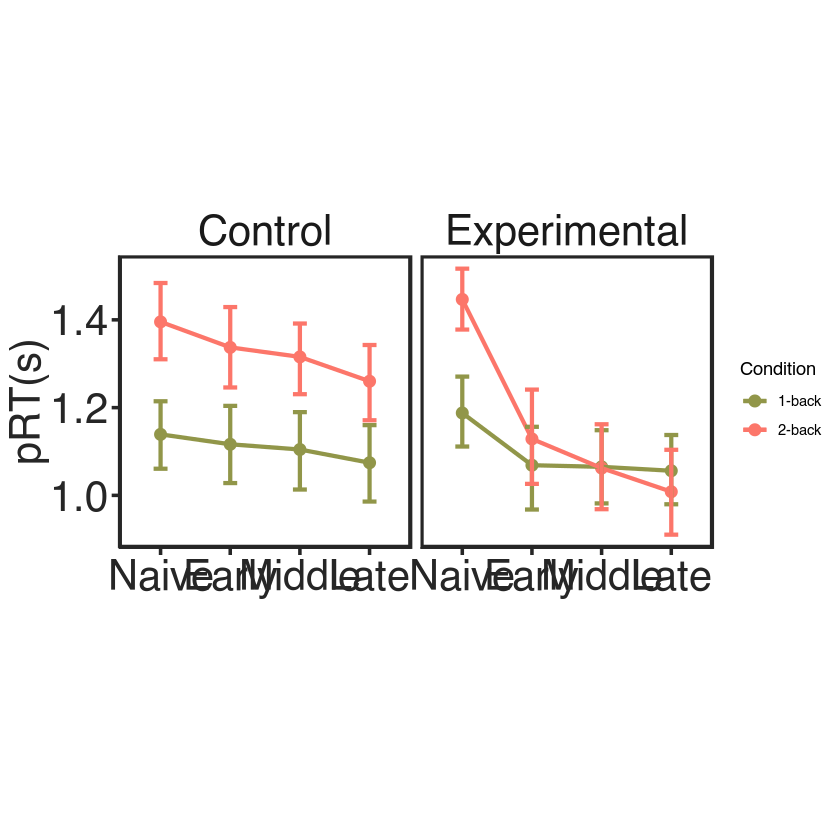

In [21]:
p <- ggplot(beh_mean, aes(x = Session, y = pRT, color = Condition)) +
    stat_summary(fun.y = mean, geom = 'point', size = 3) +
    stat_summary(fun.y = mean, geom = 'line', size = 1.2, aes(group = Condition)) +
    stat_summary(fun.data = mean_cl_boot, geom = 'errorbar', width = 0.2, size = 1.2) +
    scale_colour_manual(values=c('#919649', '#fc766a')) +
    theme_training +
    ylab('pRT(s)') +
    xlab('') +
    facet_wrap('~Group')
p

ggsave("figures/Figure_beh_fmri_pRT.pdf", plot = p, width = 12, height = 6, dpi = 300)  

Step 3: T-tests: pRT change
----------------------------------------------------

In [22]:
beh_mean_nl <- beh_mean %>% filter(Session %in% c('Naive', 'Late'))

exp1 <-  beh_mean_nl %>% filter(Group == 'Experimental') %>% filter(Condition == '1-back')
exp2 <-  beh_mean_nl %>% filter(Group == 'Experimental') %>% filter(Condition == '2-back')
con1 <-  beh_mean_nl %>% filter(Group == 'Control') %>% filter(Condition == '1-back')
con2 <-  beh_mean_nl %>% filter(Group == 'Control') %>% filter(Condition == '2-back')


In [23]:
t.test(exp1$pRT ~ exp1$Session, paired = TRUE)
t.test(exp2$pRT ~ exp2$Session, paired = TRUE)
t.test(con1$pRT ~ con1$Session, paired = TRUE)
t.test(con2$pRT ~ con2$Session, paired = TRUE)


	Paired t-test

data:  exp1$pRT by exp1$Session
t = 3.8646, df = 22, p-value = 0.0008386
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.06100609 0.20230826
sample estimates:
mean of the differences 
              0.1316572 



	Paired t-test

data:  exp2$pRT by exp2$Session
t = 10.391, df = 22, p-value = 5.985e-10
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.3507796 0.5257232
sample estimates:
mean of the differences 
              0.4382514 



	Paired t-test

data:  con1$pRT by con1$Session
t = 1.8974, df = 22, p-value = 0.07098
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.00601012  0.13524505
sample estimates:
mean of the differences 
             0.06461746 



	Paired t-test

data:  con2$pRT by con2$Session
t = 3.542, df = 22, p-value = 0.00183
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.05608824 0.21454393
sample estimates:
mean of the differences 
              0.1353161 


In [24]:
t.test(exp2[exp2$Session == 'Naive', ]$pRT - exp2[exp2$Session == 'Late', ]$pRT,
con2[con2$Session == 'Naive', ]$pRT - con2[con2$Session == 'Late', ]$pRT, paired = FALSE)

t.test(exp1[exp1$Session == 'Naive', ]$pRT - exp1[exp1$Session == 'Late', ]$pRT,
con1[con1$Session == 'Naive', ]$pRT - con1[con1$Session == 'Late', ]$pRT, paired = FALSE)



	Welch Two Sample t-test

data:  exp2[exp2$Session == "Naive", ]$pRT - exp2[exp2$Session == "Late",  and con2[con2$Session == "Naive", ]$pRT - con2[con2$Session == "Late",     ]$pRT and     ]$pRT
t = 5.3233, df = 43.576, p-value = 3.374e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1882146 0.4176560
sample estimates:
mean of x mean of y 
0.4382514 0.1353161 



	Welch Two Sample t-test

data:  exp1[exp1$Session == "Naive", ]$pRT - exp1[exp1$Session == "Late",  and con1[con1$Session == "Naive", ]$pRT - con1[con1$Session == "Late",     ]$pRT and     ]$pRT
t = 1.3917, df = 44, p-value = 0.171
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.03004117  0.16412059
sample estimates:
 mean of x  mean of y 
0.13165717 0.06461746 


In [25]:
t.test(exp1[exp1$Session == 'Late', ]$pRT, exp2[exp2$Session == 'Late', ]$pRT, paired = TRUE)


	Paired t-test

data:  exp1[exp1$Session == "Late", ]$pRT and exp2[exp2$Session == "Late", ]$pRT
t = 1.8567, df = 22, p-value = 0.07679
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.005588679  0.101160563
sample estimates:
mean of the differences 
             0.04778594 


In [26]:
beh_mean %>% 
    group_by(Session, Group, Condition) %>% filter(Session %in% c('Naive', 'Late'))%>%
    summarize(mpRT = mean(pRT), mDprime = mean(Dprime), mAcc = mean(Accuracy))
    

Session,Group,Condition,mpRT,mDprime,mAcc
Naive,Control,1-back,1.139014,3.415261,88.19928
Naive,Control,2-back,1.395395,2.279497,84.22627
Naive,Experimental,1-back,1.187759,3.198422,87.38877
Naive,Experimental,2-back,1.446567,2.100276,83.64837
Late,Control,1-back,1.074396,3.696445,88.87880
Late,Control,2-back,1.260079,2.959113,87.11775
Late,Experimental,1-back,1.056102,3.576007,89.02518
Late,Experimental,2-back,1.008316,3.545283,88.74221


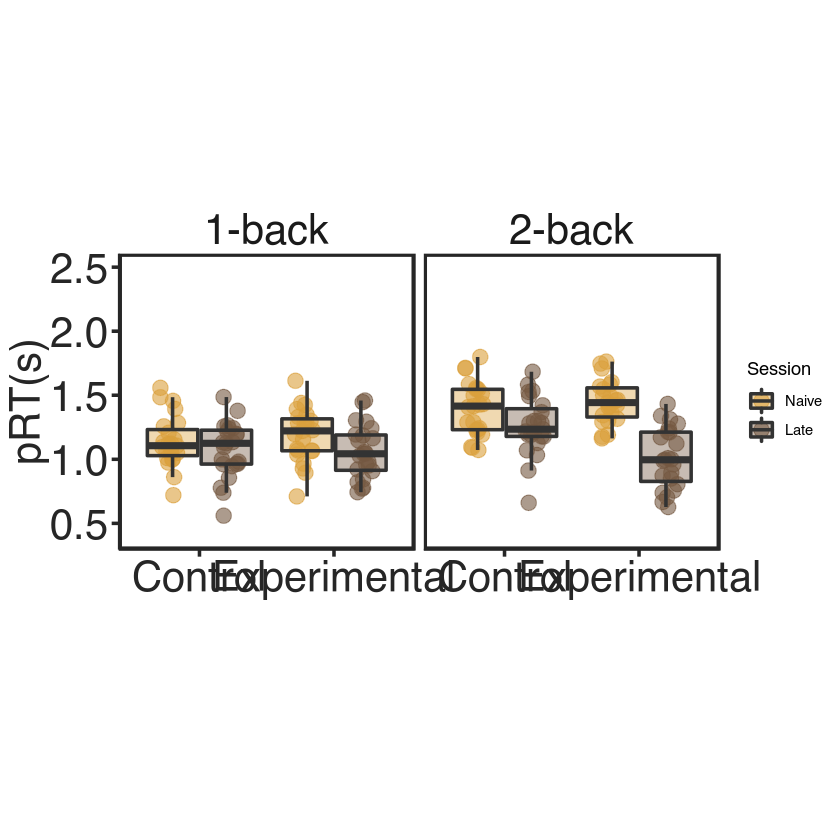

In [27]:
p <- beh_mean %>% filter(Session %in% c('Naive', 'Late')) %>%
    ggplot(aes(x = Group, y = pRT, fill = Session)) + 
    geom_point(aes(col = Session), position=position_jitterdodge(dodge.width=0.9), alpha = 0.6, size = 4) +
    geom_boxplot(alpha = 0.4, outlier.shape = NA, position=position_dodge(width=0.8), size = 1) + 
    scale_fill_manual(values=c('#daa03d', '#755841')) +
    scale_color_manual(values=c('#daa03d', '#755841')) +
    facet_wrap(~Condition) +
    ylim(0.4, 2.5) +
    ylab('pRT(s)') +
    xlab(' ') +
    theme_training
p

ggsave("figures/Figure_beh_fmri_pRT_ttests.pdf", plot = p, width = 12, height = 6, dpi = 300)  

Step 4: Multilevel modelling (MLM): d-prime change
----------------------------------------------------

In [28]:
baseline <- lme(Dprime ~ 1, random = ~ 1|Subject/Session/Condition, data = beh_mean, method = 'ML',  control = list(opt = "optim"), na.action = na.exclude)
condition <- update(baseline, .~. + Condition)
session <- update(condition, .~. + Session)
group <- update(session, .~. + Group)

condition_session <- update(group, .~. + Condition:Session)
condition_group <- update(condition_session, .~. + Condition:Group)
session_group <- update(condition_group, .~. + Session:Group)
condition_session_group <- update(session_group, .~. + Condition:Session:Group)

anova(baseline, condition, session, group, condition_session, condition_group, session_group, condition_session_group)

,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
baseline,"lme.formula(fixed = Dprime ~ 1, data = beh_mean, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",1,5,821.3526,840.8931,-405.6763,,NA,NA
condition,"lme.formula(fixed = Dprime ~ Condition, data = beh_mean, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",2,6,715.8598,739.3083,-351.9299,1 vs 2,107.492857,3.471544e-25
session,"lme.formula(fixed = Dprime ~ Condition + Session, data = beh_mean, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",3,9,649.5124,684.6851,-315.7562,2 vs 3,72.347434,1.341186e-15
group,"lme.formula(fixed = Dprime ~ Condition + Session + Group, data = beh_mean, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",4,10,648.3079,687.3887,-314.1539,3 vs 4,3.204486,7.343660e-02
condition_session,"lme.formula(fixed = Dprime ~ Condition + Session + Group + Condition:Session, data = beh_mean, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",5,13,619.5531,670.3582,-296.7766,4 vs 5,34.754748,1.372607e-07
condition_group,"lme.formula(fixed = Dprime ~ Condition + Session + Group + Condition:Session + Condition:Group, data = beh_mean, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",6,14,591.5635,646.2767,-281.7817,5 vs 6,29.989635,4.343619e-08
session_group,"lme.formula(fixed = Dprime ~ Condition + Session + Group + Condition:Session + Condition:Group + Session:Group, data = beh_mean, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",7,17,570.1098,636.5473,-268.0549,6 vs 7,27.453648,4.729221e-06
condition_session_group,"lme.formula(fixed = Dprime ~ Condition + Session + Group + Condition:Session + Condition:Group + Session:Group + Condition:Session:Group, data = beh_mean, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",8,20,566.1369,644.2986,-263.0685,7 vs 8,9.972895,1.879795e-02


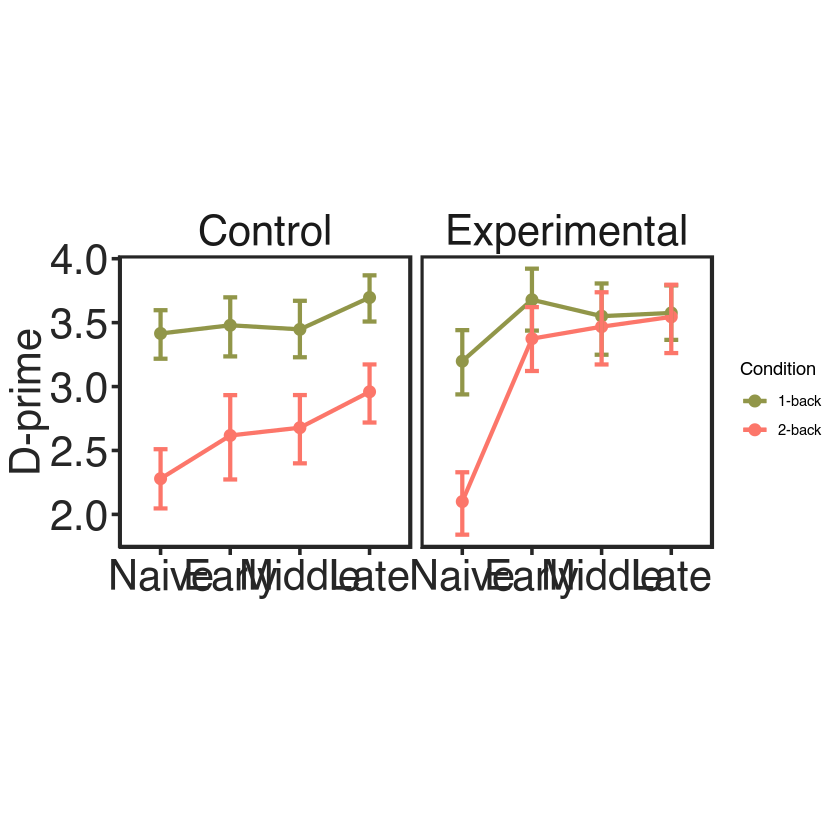

In [29]:
p <- ggplot(beh_mean, aes(x = Session, y = Dprime, color = Condition)) +
    stat_summary(fun.y = mean, geom = 'point', size = 3) +
    stat_summary(fun.y = mean, geom = 'line', size = 1.2, aes(group = Condition)) +
    stat_summary(fun.data = mean_cl_boot, geom = 'errorbar', width = 0.2, size = 1.2) +
    scale_colour_manual(values=c('#919649', '#fc766a')) +
    theme_training +
    ylab('D-prime') +
    xlab('') +
    facet_wrap('~Group')

p

ggsave("figures/Figure_beh_fmri_dprime.pdf", plot = p, width = 12, height = 6, dpi = 300)  

Step 4: T-tests: d-prime change
----------------------------------------------------

In [30]:
t.test(exp1$Dprime ~ exp1$Session, paired = TRUE)
t.test(exp2$Dprime ~ exp2$Session, paired = TRUE)
t.test(con1$Dprime ~ con1$Session, paired = TRUE)
t.test(con2$Dprime ~ con2$Session, paired = TRUE)


	Paired t-test

data:  exp1$Dprime by exp1$Session
t = -2.7833, df = 22, p-value = 0.01084
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.65892468 -0.09624512
sample estimates:
mean of the differences 
             -0.3775849 



	Paired t-test

data:  exp2$Dprime by exp2$Session
t = -9.0826, df = 22, p-value = 6.746e-09
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.774950 -1.115063
sample estimates:
mean of the differences 
              -1.445006 



	Paired t-test

data:  con1$Dprime by con1$Session
t = -2.2918, df = 22, p-value = 0.03185
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.53562674 -0.02673986
sample estimates:
mean of the differences 
             -0.2811833 



	Paired t-test

data:  con2$Dprime by con2$Session
t = -7.2499, df = 22, p-value = 2.907e-07
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.8740237 -0.4852075
sample estimates:
mean of the differences 
             -0.6796156 


In [31]:
t.test(exp2[exp2$Session == 'Naive', ]$Dprime - exp2[exp2$Session == 'Late', ]$Dprime,
con2[con2$Session == 'Naive', ]$Dprime - con2[con2$Session == 'Late', ]$Dprime, paired = FALSE)

t.test(exp1[exp1$Session == 'Naive', ]$Dprime - exp1[exp1$Session == 'Late', ]$Dprime,
con1[con1$Session == 'Naive', ]$Dprime - con1[con1$Session == 'Late', ]$Dprime, paired = FALSE)



	Welch Two Sample t-test

data:  exp2[exp2$Session == "Naive", ]$Dprime - exp2[exp2$Session ==  and con2[con2$Session == "Naive", ]$Dprime - con2[con2$Session ==     "Late", ]$Dprime and     "Late", ]$Dprime
t = -4.1449, df = 35.633, p-value = 0.0001999
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.1400298 -0.3907514
sample estimates:
 mean of x  mean of y 
-1.4450062 -0.6796156 



	Welch Two Sample t-test

data:  exp1[exp1$Session == "Naive", ]$Dprime - exp1[exp1$Session ==  and con1[con1$Session == "Naive", ]$Dprime - con1[con1$Session ==     "Late", ]$Dprime and     "Late", ]$Dprime
t = -0.52704, df = 43.563, p-value = 0.6008
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.4651378  0.2723346
sample estimates:
 mean of x  mean of y 
-0.3775849 -0.2811833 


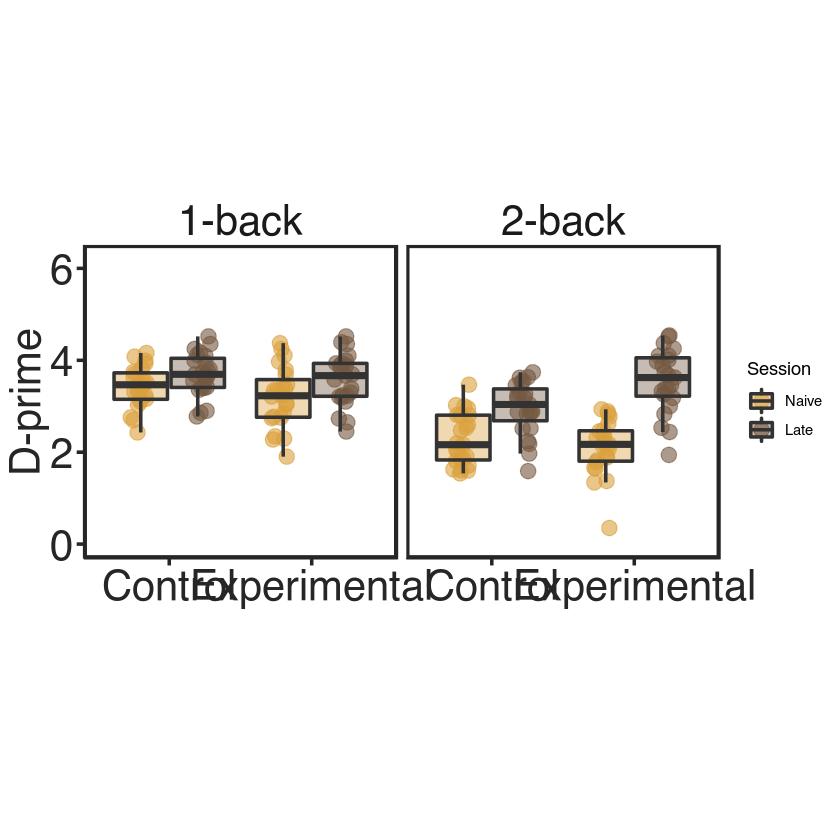

In [33]:
p <- beh_mean %>% filter(Session %in% c('Naive', 'Late')) %>%
    ggplot(aes(x = Group, y = Dprime, fill = Session)) + 
    geom_point(aes(col = Session), position=position_jitterdodge(dodge.width=0.9), alpha = 0.6, size = 4) +
    geom_boxplot(alpha = 0.4, outlier.shape = NA, position=position_dodge(width=0.8), size = 1) + 
    scale_fill_manual(values=c('#daa03d', '#755841')) +
    scale_color_manual(values=c('#daa03d', '#755841')) +
    facet_wrap(~Condition) +
    ylim(0, 6.2) +
    ylab('D-prime') +
    xlab(' ') +
    theme_training
p

ggsave("figures/Figure_beh_fmri_dprime_ttests.pdf", plot = p, width = 12, height = 5, dpi = 300)  